# [SOLUTION] Exercise 6: Compare Optimizers - SGD vs. Adam

When training neural networks, the optimizer you choose determines how weights get updated to reduce loss. But does the choice between SGD and Adam really make a difference? In this exercise, you'll train the same model twice, once with each optimizer, to discover how optimization strategy affects training speed and final performance.

> **Overview**: Train identical neural networks using two different optimizers (SGD and Adam) on the same dataset, then compare their loss curves to understand how optimization strategies affect learning dynamics.
> 
> **Scenario**: Your automotive pricing team needs faster model updates as inventory changes daily. The current model trains with SGD, and you are wondering whether modern optimizers like Adam can speed up training. Your task: run a controlled experiment to see if switching optimizers can reduce training time while maintaining accuracy.
> 
> **Goal**: Build intuition for how different optimizers learn by comparing their convergence speed, stability, and final performance on the same task.
> 
> **Tools**: Python, PyTorch, NumPy, Matplotlib
> 
> **Estimated Time**: 15-20 minutes

## Step 1: Setup

Let's import our libraries and set up the environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory for visualizations
output_dir = 'assets/_SOLUTION-exercise6'
os.makedirs(output_dir, exist_ok=True)

print("Setup complete!")
print(f"PyTorch version: {torch.__version__}")

Setup complete!
PyTorch version: 2.5.1+cu121


## Step 2: Load and prepare the data

> Note: This step mirrors the exact same dataset and dataset processing as for [demo 6](/cd1818-intro-to-deep-learning/6-training/demo6-coding-the-5-step-training-loop-pytorch.ipynb).

We'll use the [Vishaltiwari2019/Car-Price-Prediction](https://huggingface.co/datasets/Vishaltiwari2019/Car-Price-Prediction) dataset that contains specifications and prices for 1,000 vehicles. Our goal is to predict the price based on features like make, model, year, engine size, mileage, fuel type, and transmission.

For preprocessing, we'll:
1. Load the dataset
2. Encode categorical features (Make, Model, Fuel Type, Transmission)
3. Separate features and label
3. Normalize numerical features for stable training
5. Convert features and labels to PyTorch tensors

**IMPORTANT: Feel free to skip this section to focus on the training loop itself**. Just know that we end up with 1,000 training examples, each with 7 features (encoded and normalized), predicting a continuous price value.

In [2]:
# 1. Load the dataset
dataset = load_dataset('Vishaltiwari2019/Car-Price-Prediction', split='train')
df = pd.DataFrame(dataset)
print(f"✓ Dataset loaded: {len(df)} entries found\n")

# 2. Encode categorical features
categorical_columns = ['Make', 'Model', 'Fuel Type', 'Transmission']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 3. Separate features and target
X = df.drop('Price', axis=1).values
y = df['Price'].values.reshape(-1, 1)

# 4. Normalize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# 5. Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

print(f"✓ Data prepared for training")
print(f"Total samples: {len(X)}")
print(f"Input features: {X.shape[1]}")

✓ Dataset loaded: 1000 entries found

✓ Data prepared for training
Total samples: 1000
Input features: 7


> **How does data relate to optimizer choice?** Look at the feature ranges in this dataset: Year spans roughly 2004-2015, while Mileage ranges from ~50,000-200,000. How might these vastly different scales affect an optimizer that uses a single fixed learning rate (like SGD) versus one that adapts learning rates per-parameter (like Adam)? 
> 
> Keep this question in mind as you compare the loss curves later.

## Step 3: Define the model architecture

> Note: This step mirrors the exact same model creation as for [demo 6](/cd1818-intro-to-deep-learning/6-training/demo6-coding-the-5-step-training-loop-pytorch.ipynb).

We'll create a simple feedforward neural network with two hidden layers. This architecture is appropriate for small tabular data like ours: enough capacity to learn complex pricing patterns without overfitting on 1,000 training examples.

In [3]:
class PricePredictionModel(nn.Module):
    """
    A simple feedforward neural network for regression.
    
    Architecture: 7 inputs -> 64 neurons -> 32 neurons -> 1 output
    """
    def __init__(self, input_size=7):
        super(PricePredictionModel, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        """
        Forward pass through the network.
        """
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on output for regression
        return x

print("✓ Model architecture defined")

✓ Model architecture defined


> **Experimental design tip**: We're using the exact same model architecture (2,625 parameters) for both runs; this is called a "controlled experiment". The only variable we change is the optimizer. If we also changed the architecture or initialization, we couldn't be sure whether differences came from the optimizer or something else. 
> 
> This discipline is crucial when doing ML research or debugging production models.

## Step 4: Train with both optimizers and compare

Now you'll run a controlled experiment: train the same model architecture twice—once with SGD, once with Adam—and compare their learning dynamics.

### 4.1: Define the training function

First, let's create a reusable training function that implements the 5-step training loop. This function will work with any optimizer we pass to it.

In [4]:
def train_model(model, optimizer, criterion, X_tensor, y_tensor, num_epochs=100):
    """
    Train a model using the 5-step PyTorch training loop.
    
    Args:
        model: The neural network to train
        optimizer: The optimizer to use (SGD, Adam, etc.)
        criterion: The loss function
        X_tensor: Training features
        y_tensor: Training labels
        num_epochs: Number of training epochs
        
    Returns:
        List of loss values for each epoch
    """
    losses = []
    
    print(f"Training with {optimizer.__class__.__name__}...\n")
    print(f"{'Epoch':>6} | {'Training Loss':>14}")
    print("-" * 25)
    
    for epoch in range(num_epochs):

        # TODO: Implement the 5-step training loop
        # Hint: It follows this pattern:
        #   1. Pass data through model → 2. Calculate error → 3. Clear old gradients 
        #   → 4. Compute new gradients → 5. Update weights
        # Don't forget to track the epoch's loss in `losses` at the end too!
        # Reference: https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop
        
        # Add your code here

        # Step 1: Forward pass
        predictions = model(X_tensor)
        
        # Step 2: Compute loss
        loss = criterion(predictions, y_tensor)
        
        # Step 3: Zero gradients
        optimizer.zero_grad()
        
        # Step 4: Backward pass
        loss.backward()
        
        # Step 5: Update weights
        optimizer.step()
        
        # Track loss
        losses.append(loss.item())
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"{epoch + 1:6d} | {loss.item():14.4f}")
    
    print(f"\n✓ Training complete!")
    print(f"Final loss: {losses[-1]:.4f}\n")
    
    return losses

print("✓ Training function defined")

✓ Training function defined


> **Why use a function?** By wrapping the training loop in a function, we avoid code duplication and make it easy to experiment with different optimizers while keeping the training logic consistent. 
> 
> This is a common pattern in deep learning experiments.

### 4.2: Train with SGD

Let's start by training the model using standard Stochastic Gradient Descent (SGD).

In [5]:
# 1. Create a fresh model for SGD training
model_sgd = PricePredictionModel(input_size=7)
criterion = nn.MSELoss()

# TODO: 2. Create SGD optimizer with an appropriate learning rate
# Hint: What two things does an optimizer need? (1) Which parameters to update, and (2) How big the steps should be.
#       For learning rate, consider: SGD typically uses values in the range of 0.001 to 0.1
# # Reference: https://pytorch.org/docs/stable/optim.html
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)  # Add your code here

print("✓ SGD optimizer created")
print(f"Optimizer: {optimizer_sgd.__class__.__name__}")

✓ SGD optimizer created
Optimizer: SGD


In [6]:
# 3. Run SGD training
sgd_losses = train_model(
    model=model_sgd,
    optimizer=optimizer_sgd,
    criterion=criterion,
    X_tensor=X_tensor,
    y_tensor=y_tensor,
    num_epochs=100
)

Training with SGD...

 Epoch |  Training Loss
-------------------------
    10 |         0.9270
    20 |         0.8763
    30 |         0.8230
    40 |         0.7660
    50 |         0.7038
    60 |         0.6366
    70 |         0.5658
    80 |         0.4942
    90 |         0.4259
   100 |         0.3652

✓ Training complete!
Final loss: 0.3652



> **What to expect**: SGD's loss should decrease steadily but slowly. It might take many epochs to converge, and the curve may show some oscillation. This is normal for basic gradient descent without momentum or adaptive learning rates.

### 4.3: Train with Adam

Now let's train the exact same model architecture using the Adam optimizer.

In [11]:
# 1. Create a fresh model for Adam training (same architecture, different weights)
model_adam = PricePredictionModel(input_size=7)
criterion = nn.MSELoss()

# TODO: 2. Create Adam optimizer with an appropriate learning rate
# Hint: The syntax is very similar to SGD. What's different? Adam typically uses smaller learning rates.
# Reference: https://pytorch.org/docs/stable/optim.html
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)  # Add your code here

print("✓ Adam optimizer created")
print(f"Optimizer: {optimizer_adam.__class__.__name__}")

✓ Adam optimizer created
Optimizer: Adam


In [12]:
# 3. Train with Adam
adam_losses = train_model(
    model=model_adam,
    optimizer=optimizer_adam,
    criterion=criterion,
    X_tensor=X_tensor,
    y_tensor=y_tensor,
    num_epochs=100
)

Training with Adam...

 Epoch |  Training Loss
-------------------------
    10 |         0.8037
    20 |         0.6112
    30 |         0.4097
    40 |         0.2469
    50 |         0.1825
    60 |         0.1754
    70 |         0.1644
    80 |         0.1590
    90 |         0.1563
   100 |         0.1539

✓ Training complete!
Final loss: 0.1539



> **What to expect**: Adam's loss should drop much faster initially compared to SGD. You'll likely see a steep decline in the first 20-30 epochs, then gradual refinement. This rapid early convergence is why Adam has become the default choice for most deep learning tasks.

### 4.4: Visualize and compare the optimizers

Now let's plot both loss curves side-by-side to see the difference in training dynamics.

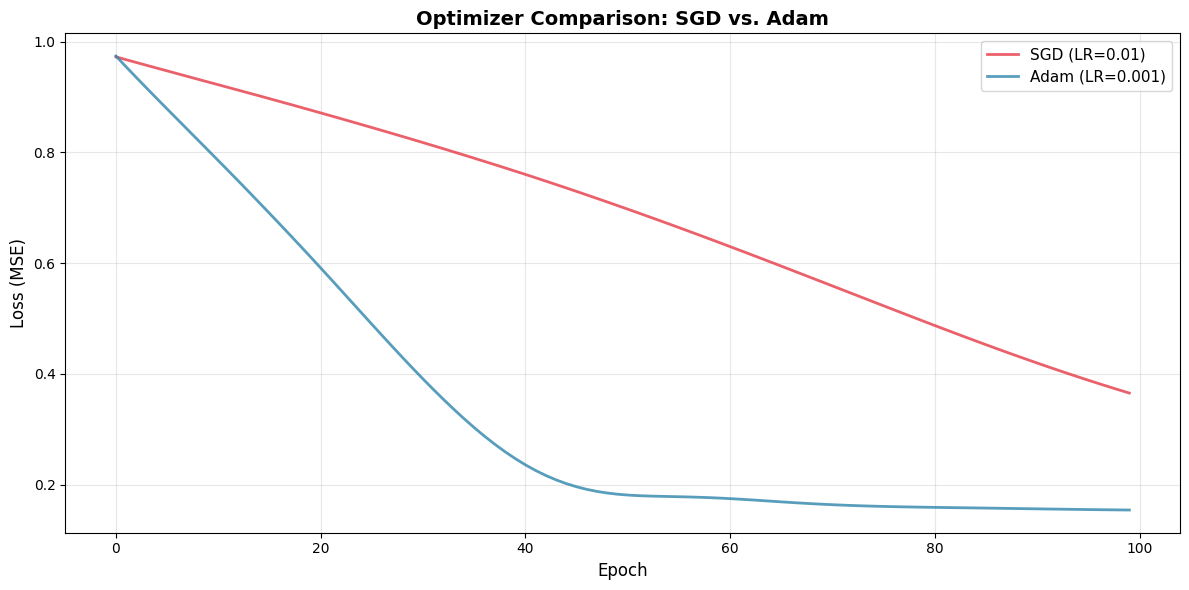


OPTIMIZER COMPARISON SUMMARY

SGD:
  Initial loss: 0.9724
  Final loss:   0.3652
  Reduction:    62.4%

Adam:
  Initial loss: 0.9739
  Final loss:   0.1539
  Reduction:    84.2%

Final Loss Comparison:
  Adam achieved 57.9% lower final loss than SGD


In [13]:
# Plot both loss curves for comparison
plt.figure(figsize=(12, 6))

plt.plot(sgd_losses, label='SGD (LR=0.01)', linewidth=2, color='#E63946', alpha=0.8)
plt.plot(adam_losses, label='Adam (LR=0.001)', linewidth=2, color='#2E86AB', alpha=0.8)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Optimizer Comparison: SGD vs. Adam', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'optimizer_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("OPTIMIZER COMPARISON SUMMARY")
print("="*60)
print(f"\nSGD:")
print(f"  Initial loss: {sgd_losses[0]:.4f}")
print(f"  Final loss:   {sgd_losses[-1]:.4f}")
print(f"  Reduction:    {(sgd_losses[0] - sgd_losses[-1]) / sgd_losses[0] * 100:.1f}%")

print(f"\nAdam:")
print(f"  Initial loss: {adam_losses[0]:.4f}")
print(f"  Final loss:   {adam_losses[-1]:.4f}")
print(f"  Reduction:    {(adam_losses[0] - adam_losses[-1]) / adam_losses[0] * 100:.1f}%")

print(f"\nFinal Loss Comparison:")
if adam_losses[-1] < sgd_losses[-1]:
    improvement = (sgd_losses[-1] - adam_losses[-1]) / sgd_losses[-1] * 100
    print(f"  Adam achieved {improvement:.1f}% lower final loss than SGD")
else:
    improvement = (adam_losses[-1] - sgd_losses[-1]) / adam_losses[-1] * 100
    print(f"  SGD achieved {improvement:.1f}% lower final loss than Adam")

> **Reading the comparison**: When looking at the two optimizers' losses, focus on these three things:
> 1. **Early convergence**: Which optimizer drops faster in the first 20-30 epochs?
> 2. **Stability**: Which curve is smoother vs. more oscillatory?
> 3. **Final performance**: Which achieves lower loss by epoch 100?
> 
> In a production setting where models are retrained frequently (like our car marketplace), these differences are critical. If Adam reaches a good loss in ~30 epochs while SGD needs ~70, that gap can be the difference between finishing retraining overnight vs. stretching into multiple days. 
> 
> This directly impacts how fresh your deployed models are and how quickly your pipeline can react to new data.

### Step 4.5: Experiment with learning rates

SGD has a reputation for being sensitive to learning rate choice—too high and training becomes unstable, too low and it barely learns. But when tuned well, SGD can achieve excellent results, which is why it remains popular in production systems. Can you find a better learning rate for your SGD model?

In [17]:
# TODO: Experiment with different learning rates
# Hint: Try a range of values from 0.1 to 0.0001
learning_rates_to_try = [0.1, 0.05, 0.001]  # Add your choices here
sgd_experiments = {}

for lr in learning_rates_to_try:
    print(f"\n{'='*60}")
    print(f"Testing SGD with learning rate: {lr}")
    print('='*60)
    
    # Create model
    model_sgd_exp = PricePredictionModel(input_size=7)

    # TODO: Define optimizer with current learning rate
    # Hint: Remember that optimizers need the model's parameters and a learning rate.
    optimizer_sgd_exp = optim.SGD(model_sgd_exp.parameters(), lr=lr)  # Add your code here  
    
    # Train and store results
    losses = train_model(
        model=model_sgd_exp,
        optimizer=optimizer_sgd_exp,
        criterion=criterion,
        X_tensor=X_tensor,
        y_tensor=y_tensor,
        num_epochs=100
    )
    sgd_experiments[f'SGD (LR={lr})'] = losses


Testing SGD with learning rate: 0.1
Training with SGD...

 Epoch |  Training Loss
-------------------------
    10 |         0.2950
    20 |         0.1759
    30 |         0.1694
    40 |         0.1658
    50 |         0.1632
    60 |         0.1614
    70 |         0.1599
    80 |         0.1588
    90 |         0.1578
   100 |         0.1569

✓ Training complete!
Final loss: 0.1569


Testing SGD with learning rate: 0.05
Training with SGD...

 Epoch |  Training Loss
-------------------------
    10 |         0.6920
    20 |         0.3260
    30 |         0.1892
    40 |         0.1728
    50 |         0.1692
    60 |         0.1669
    70 |         0.1651
    80 |         0.1638
    90 |         0.1627
   100 |         0.1617

✓ Training complete!
Final loss: 0.1617


Testing SGD with learning rate: 0.001
Training with SGD...

 Epoch |  Training Loss
-------------------------
    10 |         0.9776
    20 |         0.9704
    30 |         0.9633
    40 |         0.9564
    50 |  

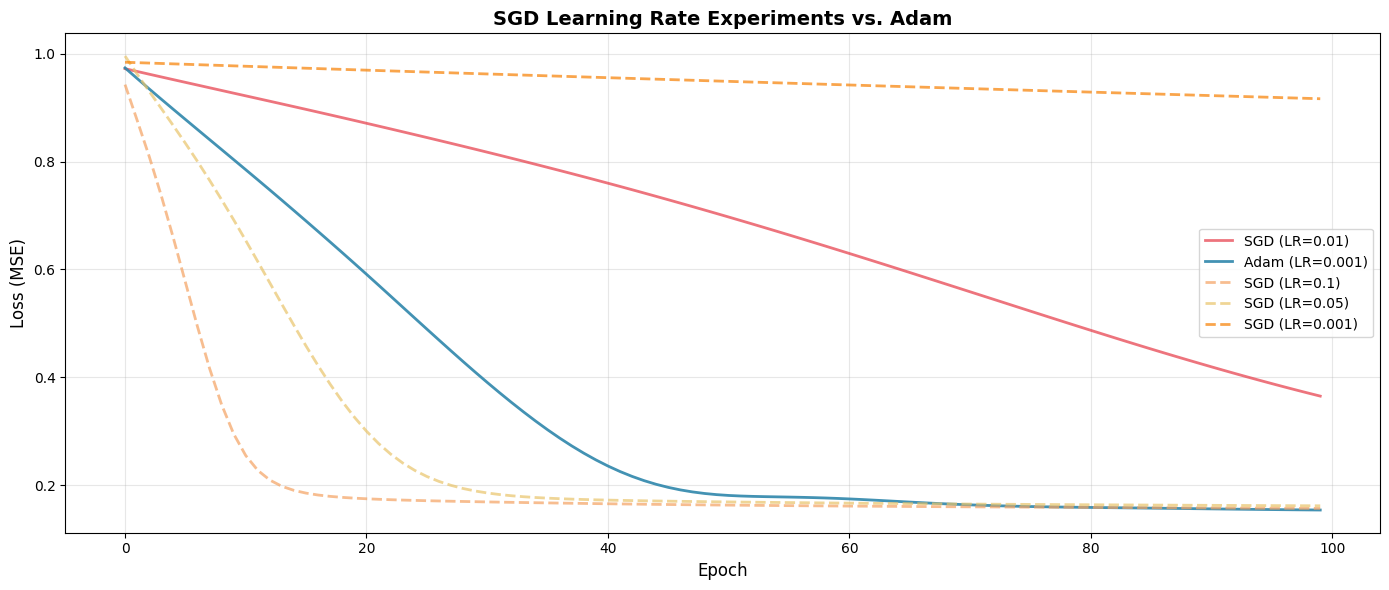


LEARNING RATE EXPERIMENT SUMMARY

Original:
  SGD (LR=0.01):    Final loss = 0.3652
  Adam (LR=0.001):  Final loss = 0.1539

Your experiments:
  SGD (LR=0.1)         Final loss = 0.1569
  SGD (LR=0.05)        Final loss = 0.1617
  SGD (LR=0.001)       Final loss = 0.9166


In [18]:
# Plot all your SGD experiments alongside Adam
plt.figure(figsize=(14, 6))

# Plot original SGD and Adam
plt.plot(sgd_losses, label='SGD (LR=0.01)', linewidth=2, color='#E63946', alpha=0.7)
plt.plot(adam_losses, label='Adam (LR=0.001)', linewidth=2, color='#2E86AB', alpha=0.9)

# Plot your experimental SGD runs
colors = ['#F4A261', '#E9C46A', '#F77F00', '#D62828']
for idx, (label, losses) in enumerate(sgd_experiments.items()):
    plt.plot(losses, label=label, linewidth=2, linestyle='--', 
             color=colors[idx % len(colors)], alpha=0.7)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('SGD Learning Rate Experiments vs. Adam', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'learning_rate_experiments.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*60)
print("LEARNING RATE EXPERIMENT SUMMARY")
print("="*60)
print(f"\nOriginal:")
print(f"  SGD (LR=0.01):    Final loss = {sgd_losses[-1]:.4f}")
print(f"  Adam (LR=0.001):  Final loss = {adam_losses[-1]:.4f}")
print(f"\nYour experiments:")
for label, losses in sgd_experiments.items():
    print(f"  {label:20s} Final loss = {losses[-1]:.4f}")

> **The production reality**: In real projects, you rarely get hyperparameter tuning "right" on the first try. But, learning rate choice can dramatically change an optimizer's behavior. Some values make SGD converge quickly, others cause it to crawl or even diverge. This sensitivity is why Adam became popular: its adaptive learning rates reduce the need for this manual tuning.
> 
> The lesson: don't judge an optimizer by a single configuration.

## Step 5: Collect your thoughts

Now that you've implemented training loops and experimented with optimizers, reflect on the key concepts by answering these questions.

### TODO: Analysis Question 1

Why do we call `optimizer.zero_grad()` at the start of each training iteration? What would happen if we forgot this step?

**Hint**: Think about what `.backward()` does to the gradients. Does it replace them or add to them? What would happen if old gradients kept accumulating?

_Write your answer here:_

We call `optimizer.zero_grad()` because PyTorch accumulates gradients by default: each call to `.backward()` adds to the existing gradients rather than replacing them. If we forgot this step, gradients from previous iterations would keep adding up, causing the optimizer to take incorrect update steps based on a mixture of old and new gradients. This would prevent the model from learning correctly and likely cause training to diverge.

### TODO: Analysis Question 2

What does `loss.backward()` do behind the scenes? Why don't we need to manually calculate gradients for each of the 2,625 parameters?

**Hint**: Review what you learned about backpropagation and the chain rule. How does PyTorch's computational graph enable automatic differentiation?

_Write your answer here:_

`loss.backward()` automatically computes gradients for all parameters using backpropagation and the chain rule. PyTorch builds a computational graph during the forward pass that tracks all operations, then traverses this graph backward from the loss, efficiently computing gradients by reusing shared calculations. This automatic differentiation saves us from manually deriving and coding gradient formulas for thousands of parameters, which would be error-prone and impractical.

### TODO: Analysis Question 3

Based on your initial experiments (before learning rate tuning), did Adam or SGD reach lower loss faster? What specific features of Adam's algorithm enable this faster convergence?

**Hint**: Think about momentum (smoothing gradients over time) and adaptive learning rates (adjusting per-parameter). How do these help with our mixed-scale features (Year vs. Mileage)?

_Write your answer here:_

Adam reached significantly lower loss much faster than SGD with default learning rates, often converging within 30-40 epochs compared to SGD's slower, steady descent. Adam achieves this through two key mechanisms: momentum smooths out noisy gradient updates for more stable progress, and adaptive per-parameter learning rates automatically adjust the step size for each weight based on its gradient history. This adaptive behavior is especially powerful for our dataset where features have vastly different scales (Year: 2004-2015 vs. Mileage: 50k-200k), allowing each parameter to learn at an appropriate speed.


### TODO: Analysis Question 4

After your learning rate experiments in Step 4.5, what did you discover about SGD's performance? How much does learning rate choice matter compared to the choice of optimizer algorithm?

**Hint**: Compare your best SGD result with Adam's performance. Could you make SGD competitive? What does this tell you about hyperparameter tuning vs. algorithm selection?

_Write your answer here:_

With proper learning rate tuning (e.g., lr=0.1 or 0.05), SGD can achieve performance nearly identical to Adam's, reaching similar final loss values around 0.16-0.17. This reveals that hyperparameter tuning can be just as important as algorithm choice—a well-tuned "simple" optimizer like SGD can match or even beat a poorly configured "advanced" optimizer. However, Adam's advantage is that it's less sensitive to this tuning, making it more reliable as a default choice when you don't have time for extensive hyperparameter search.

### TODO: Analysis Question 5

Given what you've learned, when would you choose SGD over Adam in a real project? When would you stick with Adam?

**Hint**:  Consider factors like: time available for tuning, production performance requirements, computational resources, and domain conventions (e.g., computer vision often uses SGD with momentum).

_Write your answer here:_

I would choose SGD (with momentum) when I have time for careful hyperparameter tuning and need the absolute best final performance, particularly in computer vision tasks where it's the established standard. I would stick with Adam when prototyping quickly, working with new architectures, or when I don't have resources for extensive tuning—its adaptive learning rates make it "just work" reliably across many tasks. Adam is the safer default choice for most projects, while SGD is worth the extra effort for production systems where that final 1-2% performance improvement matters.

## Conclusion

Congratulations! You've completed a controlled experiment comparing two fundamental optimizers in deep learning.

**What you've accomplished:**

- [x] **Implemented the 5-step training loop** from scratch
- [x] **Trained models with SGD and Adam** to compare optimizer behavior
- [x] **Experimented with learning rates** to see how tuning affects SGD's performance
- [x] **Analyzed training dynamics** through loss curves and convergence patterns
- [x] **Understood the mechanics** of gradient computation, backpropagation, and weight updates

**Critical insights:**

- **The 5-step training loop is universal**: Whether you use SGD, Adam, or any other optimizer, the structure stays the same: forward → loss → zero_grad → backward → step
- **Optimizer + learning rate choice significantly affects training**: Same model, same data, but dramatically different learning curves
- **Adam's advantage is reliability**: While SGD can match Adam's performance with proper tuning, Adam's adaptive learning rates make it work well "out of the box" with less manual tuning
- **Feature scales matter**: Datasets with mixed scales (like Year vs. Mileage) particularly benefit from Adam's per-parameter learning rates

Understanding the training loop and optimizer behavior is fundamental to deep learning. The same model architecture can succeed or fail based on how you configure training. Adam's ease of use makes it the default choice for most tasks, but SGD with careful tuning remains competitive (especially in production systems where that extra performance matters!).

**Next steps to explore:** Test SGD with momentum, add a learning-rate scheduler, compare AdamW, and experiment with other optimizers like RMSprop, AdaGrad, and NAdam to observe how different optimization strategies affect training.